In [1]:
# Importing required libraries

import numpy as np
import os
import subprocess as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import StrMethodFormatter
import sys

# Setting global parameters for matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True

# Defining constants
EPSILON = 1e-5
SKIP_THRESHOLD = 1e2

In [2]:
def execute_command(command):
    """Executes a shell command and returns stdout and stderr."""
    p = sp.Popen(command, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    return stdout.decode("utf-8"), stderr.decode("utf-8")

def gettingFacets(filename, Tracer):
    """Function to get facets from a given filename and Tracer value."""
    exe = ["./getFacet1", filename] if Tracer == 1 else ["./getFacet2", filename]
    _, stderr = execute_command(exe)
    temp2 = stderr.split("\n")
    temp2 = [line for line in temp2 if line.strip()]  # Remove empty lines
    segs = []

    if len(temp2) > SKIP_THRESHOLD:
        for n1 in range(0, len(temp2) - 1, 2):  # Process every other line
            temp3 = temp2[n1].split()
            temp4 = temp2[n1+1].split()
            r1, z1 = float(temp3[1]), float(temp3[0])
            r2, z2 = float(temp4[1]), float(temp4[0])
            segs.append(((r1, z1),(r2, z2)))
            segs.append(((-r1, z1),(-r2, z2)))

    return segs

def gettingfield(filename, zmin, zmax, rmax, nr, Ohf, Ohd, Ohs):
    """Function to get field data from a given filename."""
    params = [filename, zmin, 0, zmax, rmax, nr, Ohf, Ohd, Ohs]
    exe = ["./getData"] + [str(param) for param in params]
    _, stderr = execute_command(exe)
    temp2 = stderr.split("\n")
    data = [list(map(float, line.split())) for line in temp2 if len(line.split()) >= 4]
    Ztemp, Rtemp, D2temp, veltemp = zip(*data)
    R, Z, D2, vel = map(np.asarray, [Rtemp, Ztemp, D2temp, veltemp])
    nz = int(len(Z)/nr)
    for arr in [R, Z, D2, vel]:
        arr.resize((nz, nr))
    return R, Z, D2, vel, nz

def create_plot(segs, segs2, D2, vel, t, name, zmin, zmax, rmin, rmax, lw=2):
    """Function to create a plot from given data."""
    def create_colorbar(fig, ax, cntrl, label, position, formatter):
        cb = fig.add_axes(position)
        c = plt.colorbar(cntrl, cax=cb, orientation='horizontal')
        c.set_label(label, fontsize=TickLabel, labelpad=5)
        c.ax.tick_params(labelsize=TickLabel)
        c.ax.xaxis.set_major_formatter(formatter)
        return c

    AxesLabel, TickLabel = [50, 20]
    fig, ax = plt.subplots()
    fig.set_size_inches(19.20, 10.80)

    ## Drawing Facets
    ax.add_collection(LineCollection(segs2, linewidths=2, colors='gray', linestyle='solid'))
    ax.add_collection(LineCollection(segs, linewidths=4, colors='#9970ab', linestyle='solid'))

    ## D and V
    imshow_props = {"interpolation": 'None', "origin": 'lower', "extent": [rmin, rmax, zmin, zmax]}
    cntrl1 = ax.imshow(D2, **imshow_props, cmap="hot_r", vmax=2.0, vmin=-3.0)
    imshow_props = {"interpolation": 'None', "origin": 'lower', "extent": [-rmin, -rmax, zmin, zmax]}
    cntrl2 = ax.imshow(vel, **imshow_props, cmap="Blues", vmax=4.0, vmin=0.0)

    ax.plot([0, 0], [zmin, zmax],'-.',color='grey',linewidth=lw)
    ax.plot([-rmax, -rmax], [zmin, zmax],'-',color='black',linewidth=lw)
    ax.plot([-rmax, rmax], [zmin, zmin],'-',color='black',linewidth=lw)
    ax.plot([-rmax, rmax], [zmax, zmax],'-',color='black',linewidth=lw)
    ax.plot([rmax, rmax], [zmin, zmax],'-',color='black',linewidth=lw)

    ax.set_aspect('equal')
    ax.set_xlim(-rmax, rmax)
    ax.set_ylim(zmin, zmax)
    ax.set_title('$t/t_\gamma$ = %5.4f' % t, fontsize=TickLabel)

    l, b, w, h = ax.get_position().bounds

    create_colorbar(fig, ax, cntrl1, '$\log_{10}\left(\\varepsilon_\eta\\right)$', [l+0.55*w, b-0.05, 0.40*w, 0.03], StrMethodFormatter('{x:,.1f}'))
    create_colorbar(fig, ax, cntrl2, '$\|v_i\|/V_\gamma$', [l+0.05*w, b-0.05, 0.40*w, 0.03], StrMethodFormatter('{x:,.2f}'))

    ax.axis('off')

    plt.savefig(name, bbox_inches='tight')
    # plt.close()
    plt.show()
# ----------------------------------------------------------------------------------------------------------------------


In [4]:
nr = 750
hf, Ldomain = 0.1, 2.5 #map(float, sys.argv[1:3])
Ohf, Ohd = 1e-2, 1e-2 #map(float, sys.argv[3:5])
Ohs = EPSILON 

rmin, rmax, zmin, zmax = [-Ldomain, Ldomain, -hf*1.001, Ldomain-hf*1.001]
lw = 4
folder = 'Video'  # output folder

if not os.path.isdir(folder):
    os.makedirs(folder)

test.pdf Image present!


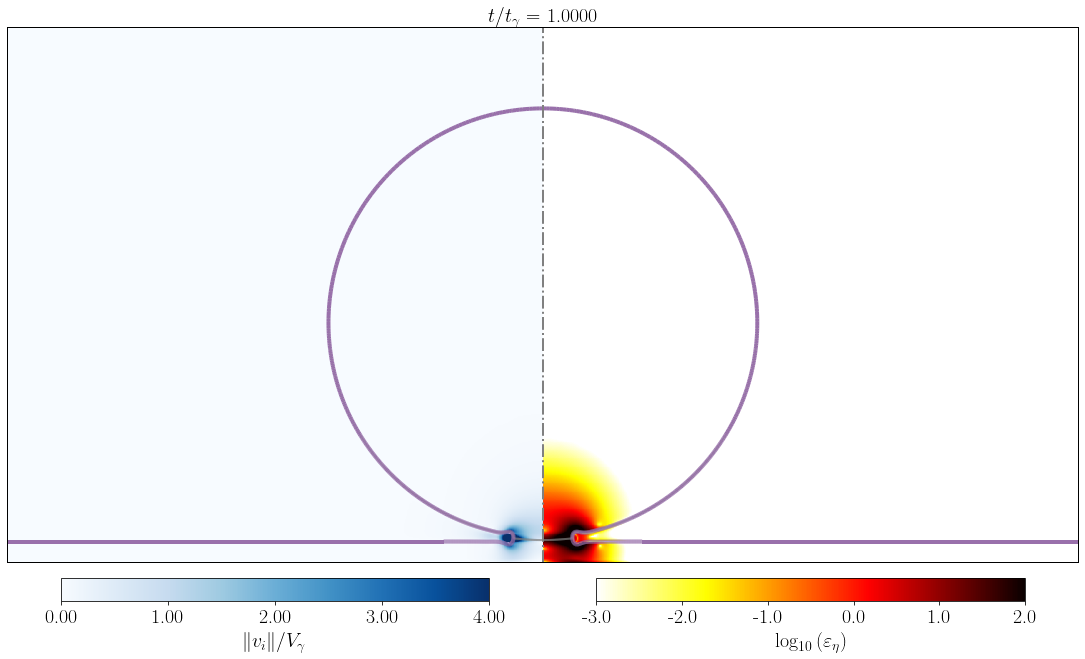

In [6]:
# t = 0.05
# print("Time is %f" % t)

# place = "intermediate/snapshot-%5.4f" % t
# name = "%s/%8.8d.png" %(folder, int(t*100000))

t = 1
place = "dump"
name = "test.pdf"

# If the file is not present or if the image is present, skip to next iteration
name_exists = os.path.exists(name)
if not os.path.exists(place) or name_exists:
    print(f"{place if not name_exists else name} {'File not found!' if not name_exists else 'Image present!'}")
    # continue

# Get the segments and field data
segs = gettingFacets(place, 1)
if not segs:
    print("Problem in the available file %s" % place)
    # continue  # Skip to next iteration if no segments found

# get the drop-film interface
segs2 = gettingFacets(place, 2)
R, Z, D2, vel, nz = gettingfield(place, zmin, zmax, rmax, nr, Ohf, Ohd, Ohs)
zminp, zmaxp, rminp, rmaxp = Z.min(), Z.max(), R.min(), R.max()

create_plot(segs, segs2, D2, vel, t, name, zminp, zmaxp, rminp, rmaxp, lw=2)